In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap

d:\anaconda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('D:/Term7/Capstone-Project-I/data/processed/preprocessed_data.csv')

In [4]:
X = df.drop("Disease", axis=1)
y = df["Disease"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
X_test.to_csv("../data/raw/X_test.csv", index=False) # index=False prevents saving the DataFrame index
y_test.to_csv("../data/raw/y_test.csv", index=False)

In [7]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

d:\anaconda\envs\env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [22]:
value_counts = pd.Series(y_train_resampled).value_counts()

In [23]:
print("After SMOTE:", value_counts )

After SMOTE: Disease
10    7
33    7
3     7
5     7
25    7
38    7
1     7
17    7
16    7
4     7
6     7
21    7
13    7
34    7
27    7
8     7
26    7
2     7
9     7
28    7
29    7
37    7
39    7
24    7
15    7
11    7
31    7
32    7
40    7
22    7
14    7
0     7
7     7
12    7
19    7
18    7
36    7
23    7
20    7
30    7
35    7
Name: count, dtype: int64


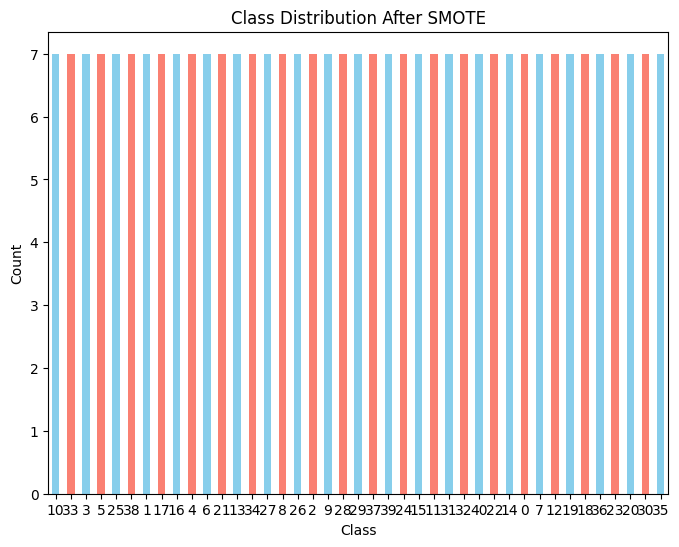

In [24]:
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['skyblue', 'salmon']) # you can change the colors
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


In [8]:
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
rf_pipeline = RandomForestClassifier(n_estimators=100, random_state=42)
catboost_pipeline = cb.CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
lgb_pipeline = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
nb_pipeline = GaussianNB()
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

In [9]:
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_pipeline),
    ('rf', rf_pipeline),
    ('catboost', catboost_pipeline),
    ('lgb', lgb_pipeline),
    ('nb', nb_pipeline),
    ('svm', svm_pipeline)
], voting='soft', n_jobs=-1)

In [10]:
param_grid = {
    'lr__logisticregression__C': [0.1, 1, 10],
    'rf__n_estimators': [100, 200],
    'catboost__iterations': [300, 500],
    'lgb__learning_rate': [0.01, 0.1],
    'svm__svc__C': [0.1, 1, 10]
}

In [11]:
grid_search = GridSearchCV(voting_clf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler()),
                                                                     ('logisticregression',
                                                                      LogisticRegression(solver='liblinear'))])),
                                                    ('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('catboost',
                                                     <catboost.core.CatBoostClassifier object at 0x0000012349F03040>),
                                                    ('lgb', LGBMClassifier()),
                                                    ('nb', GaussianNB()),
                                                    ('svm',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler()),
                                                                     ('svc',
                                                                      SVC(kernel='linear',
                                                                          probability=True))]))],
                                        n_jobs=-1, voting='soft'),
             n_jobs=-1,
             param_grid={'catboost__iterations': [300, 500],
                         'lgb__learning_rate': [0.01, 0.1],
                         'lr__logisticregression__C': [0.1, 1, 10],
                         'rf__n_estimators': [100, 200],
                         'svm__svc__C': [0.1, 1, 10]},
             verbose=2)

In [12]:
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'catboost__iterations': 500, 'lgb__learning_rate': 0.1, 'lr__logisticregression__C': 1, 'rf__n_estimators': 100, 'svm__svc__C': 1}


In [29]:
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Correct Predictions
correct_predictions = (y_pred == y_test)
num_correct = correct_predictions.sum()

# Display results
print(f"Number of correct predictions: {num_correct} out of {len(y_test)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Display the probabilities for the first few predictions
print("\nProbabilities for the first 5 predictions:")
for i in range(min(5, len(y_pred_proba))):
    print(f"Sample {i+1}:")
    for j, prob in enumerate(y_pred_proba[i]):
        print(f"  Probability of class {best_model.classes_[j]}: {prob:.4f}")
    print(f"  Predicted class: {y_pred[i]}, Actual Class: {y_test.iloc[i]}")

Number of correct predictions: 109 out of 123
Accuracy: 0.8861788617886179

Probabilities for the first 5 predictions:
Sample 1:
  Probability of class 0: 0.0077
  Probability of class 1: 0.5130
  Probability of class 2: 0.0300
  Probability of class 3: 0.0024
  Probability of class 4: 0.0265
  Probability of class 5: 0.0081
  Probability of class 6: 0.0031
  Probability of class 7: 0.0073
  Probability of class 8: 0.0017
  Probability of class 9: 0.0018
  Probability of class 10: 0.0024
  Probability of class 11: 0.0022
  Probability of class 12: 0.0016
  Probability of class 13: 0.0070
  Probability of class 14: 0.0049
  Probability of class 15: 0.0239
  Probability of class 16: 0.0021
  Probability of class 17: 0.0217
  Probability of class 18: 0.0219
  Probability of class 19: 0.0026
  Probability of class 20: 0.0088
  Probability of class 21: 0.0033
  Probability of class 22: 0.0029
  Probability of class 23: 0.0075
  Probability of class 24: 0.0030
  Probability of class 25: 0.00

In [33]:
import joblib
disease_encoder = joblib.load("../src/models/disease_encoder.joblib")

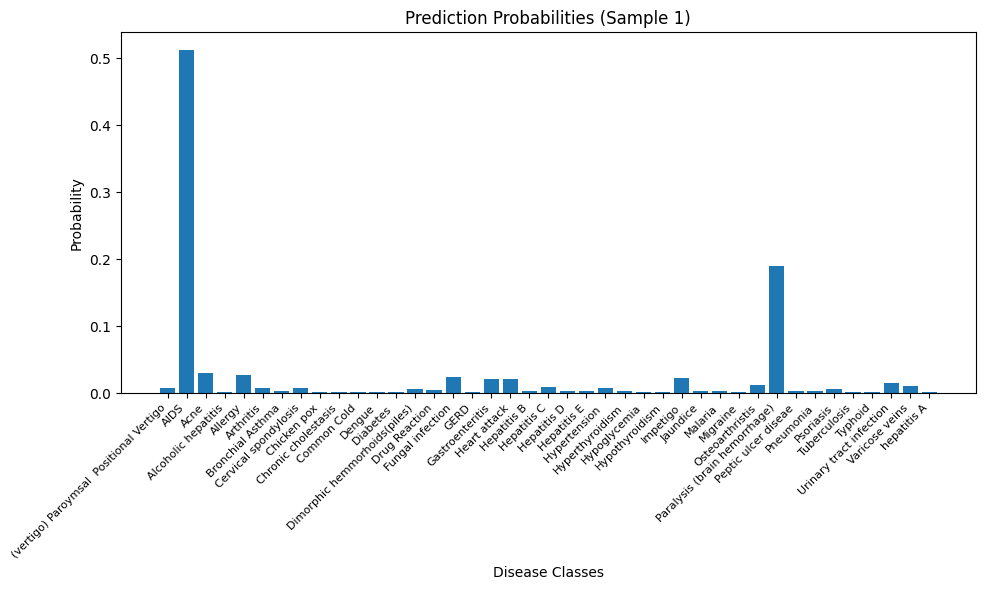

Predicted class: AIDS, Actual Class: AIDS


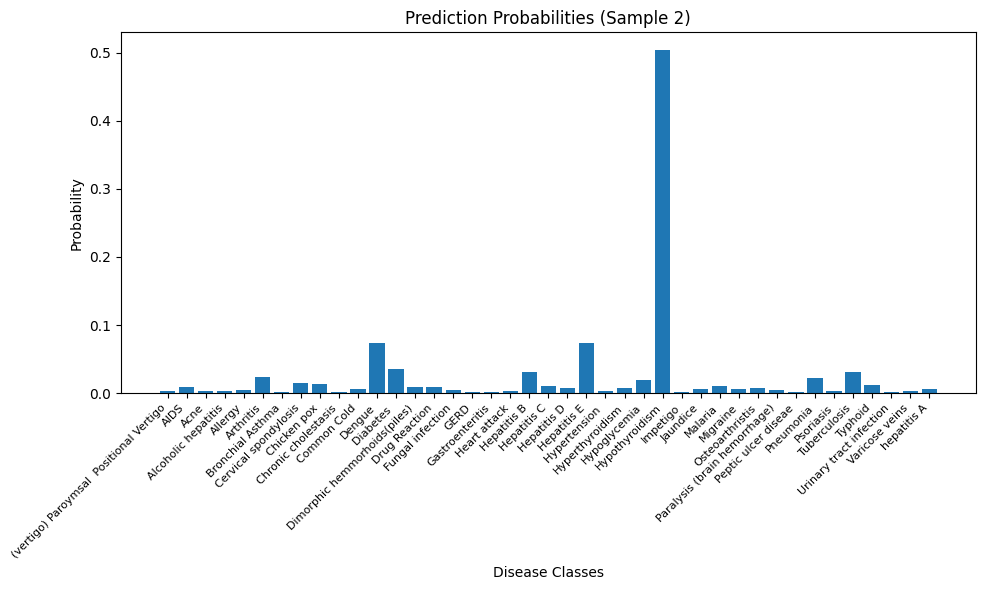

Predicted class: Hypothyroidism, Actual Class: Hepatitis E


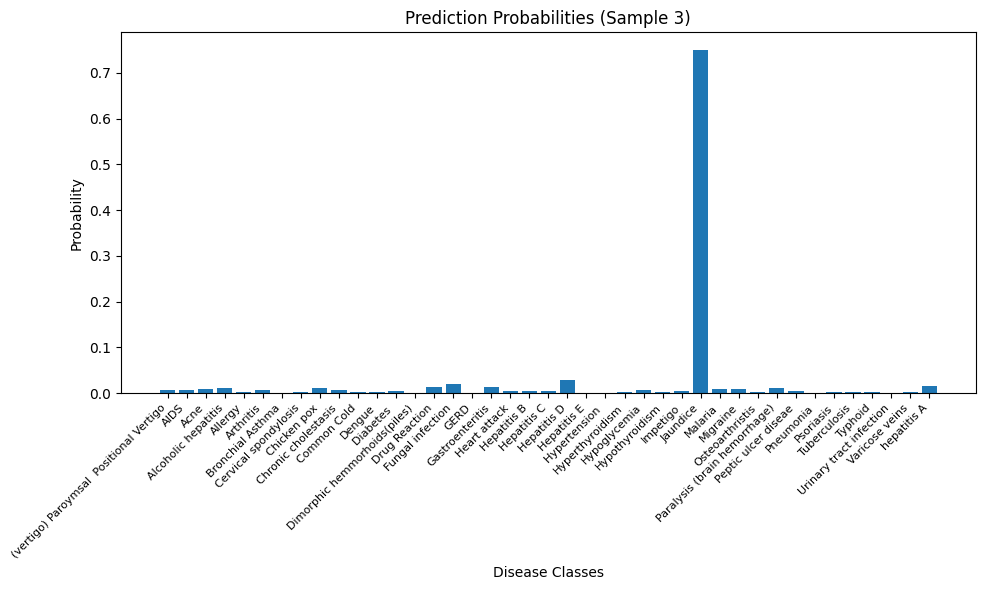

Predicted class: Jaundice, Actual Class: Jaundice


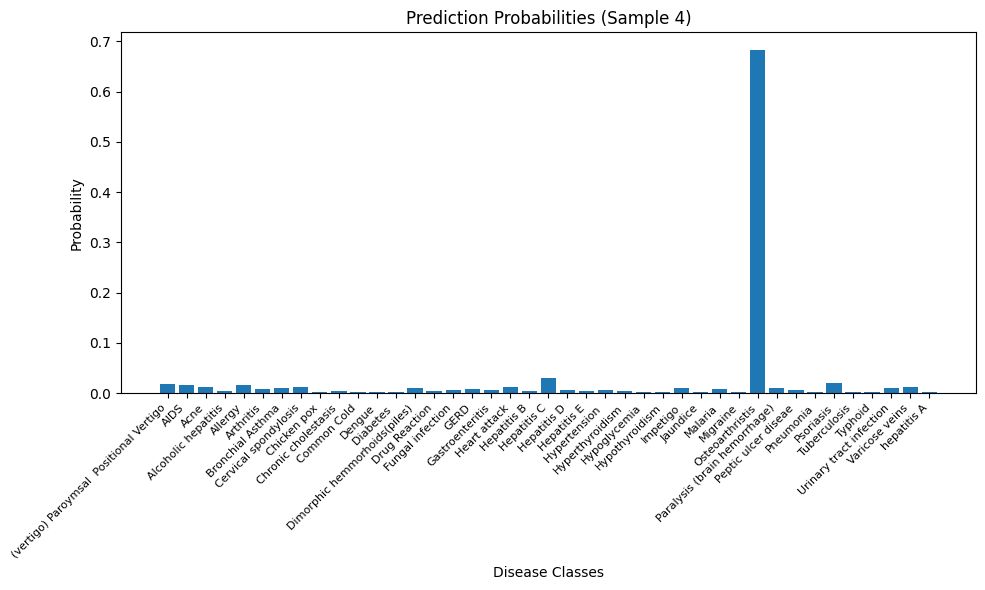

Predicted class: Osteoarthristis, Actual Class: Osteoarthristis


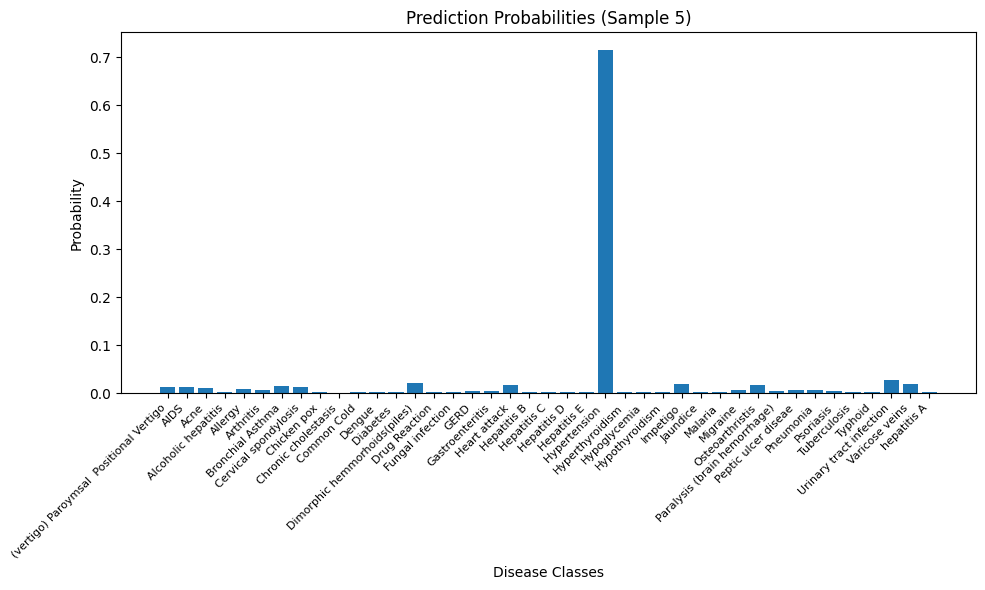

Predicted class: Hypertension , Actual Class: Hypertension 


In [35]:
for i in range(min(5, len(y_pred_proba))):
    plt.figure(figsize=(10, 6))
    disease_names = disease_encoder.classes_ # Get disease names from the encoder
    plt.bar(disease_names, y_pred_proba[i])
    plt.xlabel("Disease Classes")
    plt.ylabel("Probability")
    plt.title(f"Prediction Probabilities (Sample {i+1})")
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()

    predicted_disease = disease_encoder.classes_[y_pred[i]] #get the predicted disease name
    actual_disease = disease_encoder.classes_[y_test.iloc[i]] #get the actual disease name

    print(f"Predicted class: {predicted_disease}, Actual Class: {actual_disease}")

In [13]:
y_pred = best_model.predict(X_test)

In [14]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8861788617886179

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       0.50      0.67      0.57         3
          15       1.00      0.67      0.80         3
          16       1.00   

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)


Accuracy: 0.8861788617886179


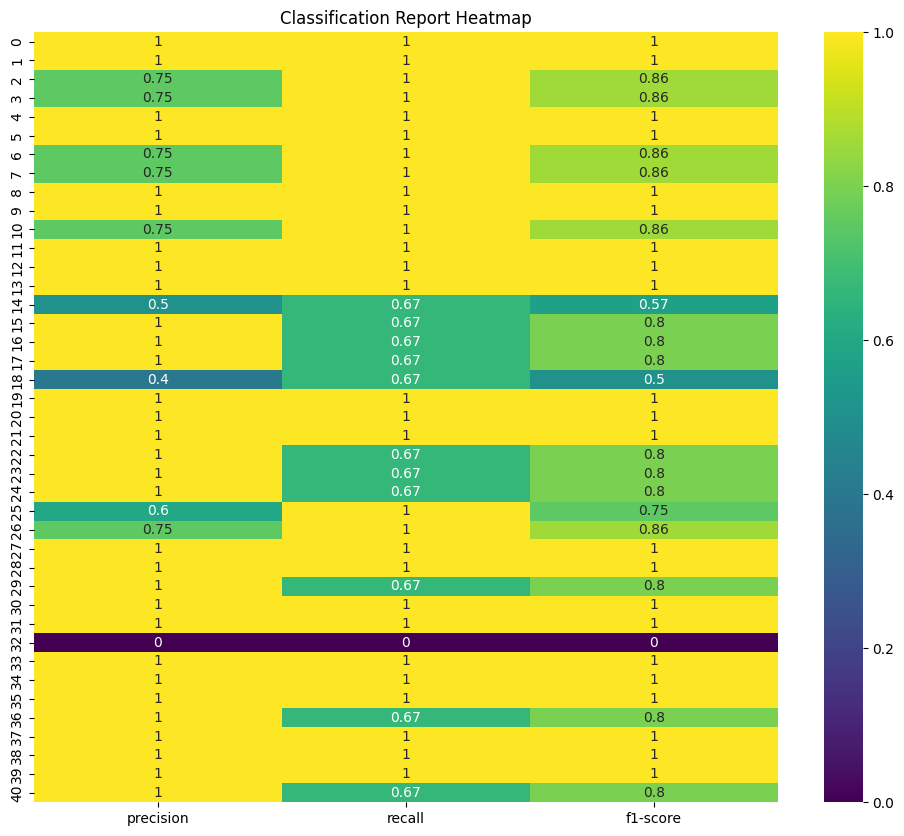

In [27]:
df_report = pd.DataFrame(report).transpose()
df_report = df_report.iloc[:-3] #remove accuracy, macro avg, weighted avg rows.

plt.figure(figsize=(12, 10))
sns.heatmap(df_report[['precision', 'recall', 'f1-score']], annot=True, cmap='viridis')
plt.title('Classification Report Heatmap')
plt.show()

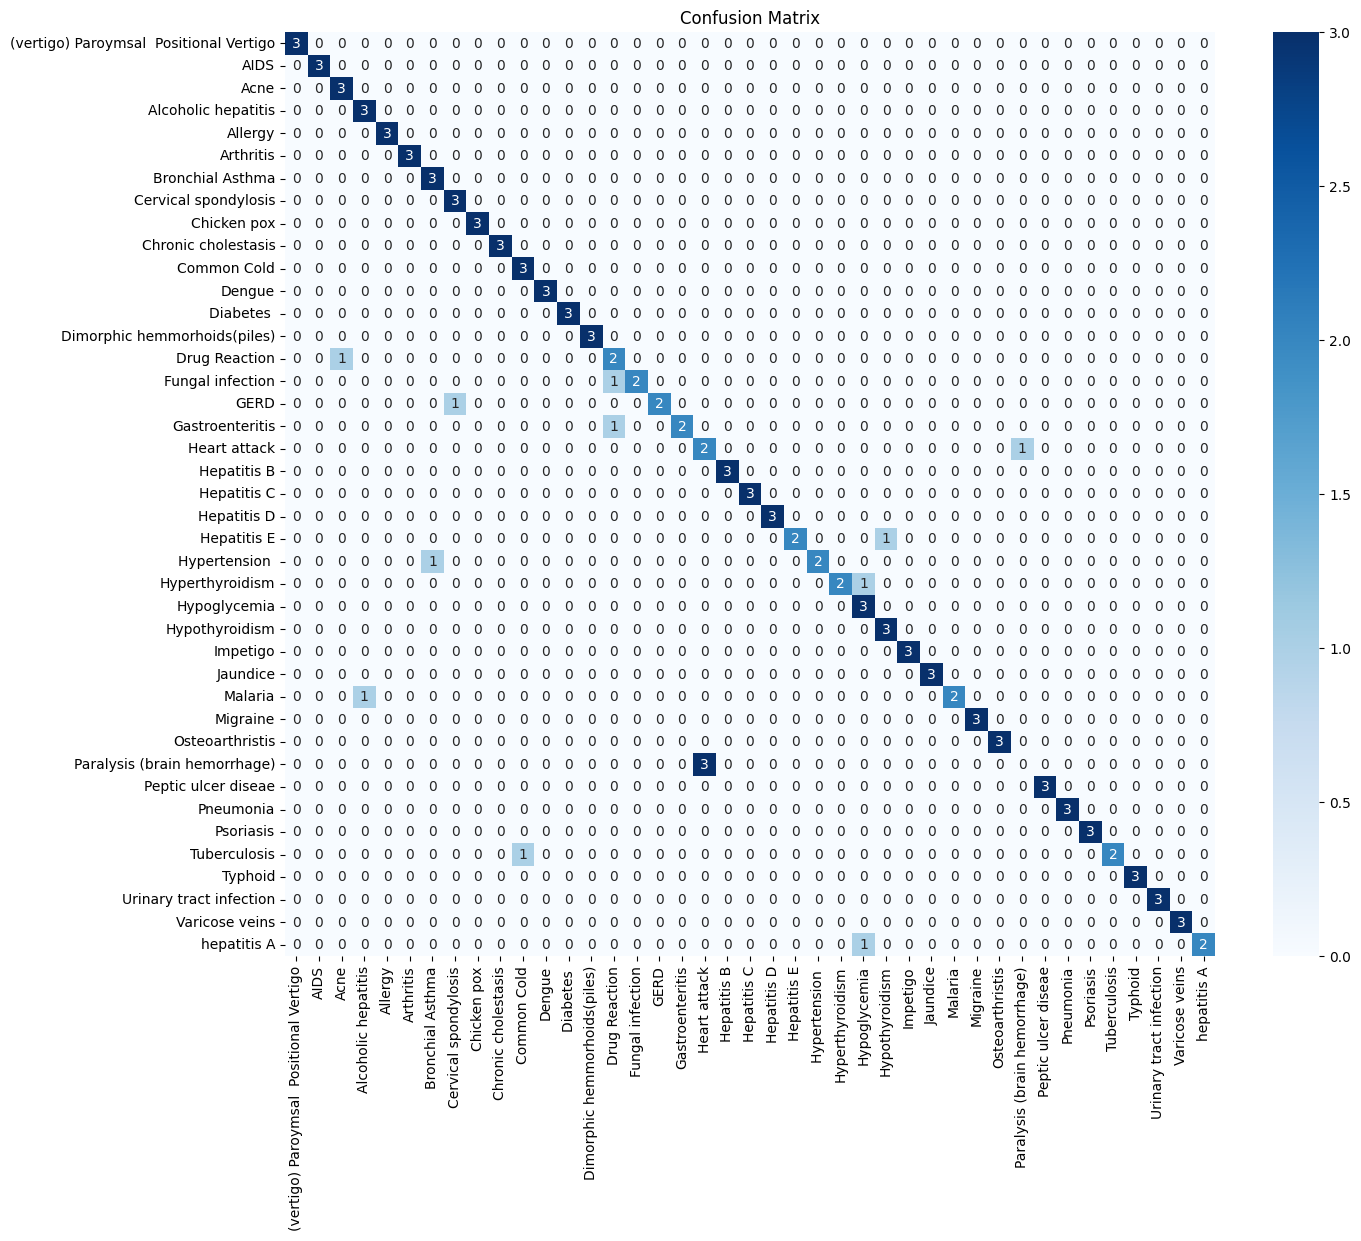

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_encoder.classes_, yticklabels=disease_encoder.classes_)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(best_model, '../src/models/best_ensemble_model.joblib') 

['../src/modelsbest_ensemble_model.joblib']